In [1]:
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import os
import random
from shutil import copyfile
assert torch.cuda.is_available(), "Missing CUDA"

1.21.2


In [2]:
torch.version.cuda

'10.2'

In [3]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.get_device_properties(0)

# Set Seeds for Reproducibility

In [4]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Get Data

In [5]:
from datasets import LoadDataset, CustomOutput
from datasets.custom_output import image_tensor, bounding_boxes
from trafo.randomize.default_augmentation import default_augmentation_only_geometric

loaded_data = LoadDataset("_data/preprocessed256_new", image_dtype=float,
                          label_dtype=float)

dataset = CustomOutput(loaded_data, image_tensor, bounding_boxes, trafo=default_augmentation_only_geometric)

In [6]:
len(dataset)

6334

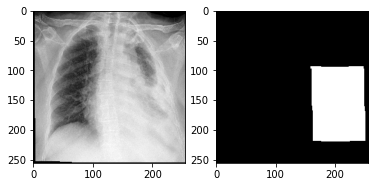

In [7]:
i_img = 42
example_img = dataset_aug[i_img]

fig, ax = plt.subplots(1,2)
plt.gray()
ax[0].imshow(example_img[0][0])
ax[1].imshow(example_img[1][0])
plt.show()

In [8]:
dataset[42][1].shape

torch.Size([1, 256, 256])

In [9]:
# get good split of dataset -> dividable by batch_size
batch_size = 16
l = len(dataset)
x = l // (batch_size *6 )
split = [x * batch_size * 5, l - x * batch_size * 5]
print(split)
train_set, val_set = torch.utils.data.random_split(dataset, split)

[5120, 1214]


In [10]:
dataloader_train = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=0)#, pin_memory = True)
dataloader_val = DataLoader(val_set, batch_size=batch_size,
                        shuffle=True, num_workers=0, pin_memory = True)

# Get Network

In [11]:
from network.unet import Unet

# Get Training

In [12]:
from network.Model import OurModel
from network.losses import DiceLoss, BCEandDiceLoss

In [13]:
import torch.nn as nn
#criterion = nn.CrossEntropyLoss().cuda()
#criterion = DiceLoss() # use binary cross entropy loss!
criterion = BCEandDiceLoss()
#criterion = nn.BCELoss().cuda()
network = Unet()
path = f"./_trainings/{datetime.now().strftime('%d-%m_%H-%M')}"
if os.path.exists(path):
    print("PATH already exists")
else:
    print(f"Make {path} directory")
    os.makedirs(path)

Make ./_trainings/16-09_12-58 directory


In [14]:
Model = OurModel(name = "unet", network=network, criterion=criterion, path_dir=path, lr=0.001,
                 batch_size = batch_size, verbose = True, segmentation=True, data_trafo=dataset.trafo)
# save a json file which indicates what parameters are used for training
Model.save_configuration()

In [15]:
%%javascript
// copy the current version of the jupyter-notebook in the chosen directory (for documentation of the used code and
// setting...)
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [16]:
nb_name

'TrainingUnet.ipynb'

In [17]:
copyfile(os.path.join(os.getcwd(), nb_name), os.path.join(path, nb_name))

'./_trainings/16-09_12-58/TrainingUnet.ipynb'

In [18]:
Model.train(100, dataloader_train, validate = True,
            dataloader_val=dataloader_val, save_observables = True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

/home/students/patzig/aml37/.venv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch1: training_loss = 1.3632669888436795
epoch1: training_dice = 0.3179839624397573


  0%|          | 0/38 [00:00<?, ?it/s]

epoch1: validation_loss = 1.2858901463056867
epoch1: validation_dice = 0.3226826245847501


  0%|          | 0/160 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#Model.load_weights(f"/Unet_first_try_e50.ckpt")

In [ ]:
"""for x,y in dataloader_val:
    Model.network.eval()
    y_hat = Model.network(x.float().cuda())
    break

y_hat = y_hat.cpu()
y_hat = y_hat.detach().numpy()
y = y.numpy()
fig, ax = plt.subplots(len(y_hat),3, figsize=(10, 100))
for i in range(len(y_hat)):
    ax[i,0].imshow(y_hat[i])
    ax[i,1].imshow(np.round(y_hat[i]))
    ax[i,2].imshow(y[i])
"""